In [1]:
### First get data.

import numpy as np
from keras.utils.np_utils import to_categorical # Just for one-hots!
import random
import os

os.chdir(r"C:\Users\tedjt\Desktop\OIST\A313")
raw_text = open("wonderland.txt", 'r', encoding='utf-8').read()
raw_text = raw_text.lower().replace("\n", " ")

chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

n_chars, n_vocab = len(raw_text), len(chars)
seq_length = 25
data_x, data_y = [], []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    data_x.append([char_to_int[char] for char in seq_in])
    data_y.append(char_to_int[seq_out])
n_patterns = len(data_x)

x = np.reshape(data_x, (n_patterns, seq_length))
x = to_categorical(data_x)
y = to_categorical(data_y)

x_keep, y_keep = x, y

print("Length of Alice in Wonderland: \t{} characters.".format(n_chars))
print("Different characters: \t\t{} characters.".format(n_vocab))
print("There are {} sequences of {} characters in a row.".format(n_patterns, seq_length))

def train_test(xs, ys, train_percent = .85):
    index = [i for i in range(len(ys))]
    random.shuffle(index)
    train_index = index[:int(train_percent * len(index))]
    test_index = index[int(train_percent * len(index)):]
    
    x_train = xs[train_index]
    x_test = xs[test_index]
    y_train = ys[train_index]
    y_test = ys[test_index]
    
    return(x_train, x_test, y_train, y_test)
    
x_train, x_test, y_train, y_test = train_test(x, y)
print("\nTrain: \n\t Input: {0}, \t Output: {1}.".format(x_train.shape, y_train.shape))
print("\nTest: \n\t Input: {0}, \t Output: {1}.".format(x_test.shape, y_test.shape))

def get_batch(test = False, size = 64):
    if(test): x, y = x_test, y_test
    else:     x, y = x_train, y_train
    index = [i for i in range(len(y))]
    random.shuffle(index)
    index = index[:size]
    x, y = x[index], y[index]
    return(x, y)

Length of Alice in Wonderland: 	143426 characters.
Different characters: 		38 characters.
There are 143401 sequences of 25 characters in a row.

Train: 
	 Input: (121890, 25, 38), 	 Output: (121890, 38).

Test: 
	 Input: (21511, 25, 38), 	 Output: (21511, 38).


In [2]:
import torch
from torch import nn
from torch.optim import Rprop
from torchinfo import summary

class Cheat(nn.Module):
    def __init__(self):
        super(Cheat, self).__init__()
        
        self.rnn = nn.RNN(
            input_size = n_vocab,
            hidden_size = 256, batch_first = True, bias = True)
        
        self.lin = nn.Linear(
            in_features = 256,
            out_features = n_vocab, bias = True)
        
    def forward(self, x):
        if(type(x) == np.ndarray): x = torch.tensor(x)
        if(len(x.shape) == 2): x = x.unsqueeze(0)
        x, _ = self.rnn(x)
        x = x[:,-1,:]
        x = self.lin(x)
        return(x)
    
cheat = Cheat()
opti = Rprop(cheat.parameters())
print("\n{}\n\n\n{}\n".format(cheat, summary(cheat, (1, seq_length, n_vocab))))
cheat = cheat.cpu()


Cheat(
  (rnn): RNN(38, 256, batch_first=True)
  (lin): Linear(in_features=256, out_features=38, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Cheat                                    --                        --
├─RNN: 1-1                               [1, 25, 256]              75,776
├─Linear: 1-2                            [1, 38]                   9,766
Total params: 85,542
Trainable params: 85,542
Non-trainable params: 0
Total mult-adds (M): 1.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.34
Estimated Total Size (MB): 0.40



In [3]:
def try_it(times = 1, length = 10):
    cheat.eval()
    index = [i for i in range(x_test.shape[0])]
    random.shuffle(index)
    index = index[:times]
    xs = x_test[index]
    
    for x in xs:
        x_ = np.argmax(x, 1)
        x_ = ''.join([int_to_char[x_[i]] for i in range(seq_length)])
        pred_list = []
        for i in range(length):
            pred = cheat(x).detach().numpy()
            pred_list.append(int_to_char[np.argmax(pred)])
            pred = np.expand_dims(to_categorical(char_to_int[pred_list[-1]], num_classes = n_vocab), axis = 0)
            x = np.vstack([x[1:], pred])
        print("\nGiven:\n\t'{}'\n\npredicted:\n\t'{}'".format(x_, x_ + " | " + "".join(pred_list)))
    
try_it()


Given:
	'n a jar from one of the s'

predicted:
	'n a jar from one of the s | yuayuy'ujq'


In [4]:
def try_it_easier(length = 10):
    index = [i for i in range(x_keep.shape[0]-(length + seq_length))]
    random.shuffle(index)
    index = index[0]
    pred_list = []
    for i in range(length):
        seq_in = raw_text[index + i : index + i + seq_length]
        seq_in = [char_to_int[char] for char in seq_in]
        seq_in = to_categorical(seq_in, n_vocab)
        pred = cheat(seq_in).detach().numpy()
        pred_list.append(int_to_char[np.argmax(pred)])
    print("\nGiven:\n\t'{}'\n\npredicted:\n\t'{}'".format(
        raw_text[index : index + seq_length] + " | " + raw_text[index + seq_length : index + length + seq_length], 
        raw_text[index : index + seq_length] + " | " + "".join(pred_list)))

try_it_easier()


Given:
	'. 'who are you?'  which b | rought the'

predicted:
	'. 'who are you?'  which b | yuaa"aa))('


In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
crit = nn.CrossEntropyLoss()

def train(epochs = 64, batch_size = 64):
    losses = []
    for e in tqdm(range(epochs)):
        cheat.train()
        x, y = get_batch(test = False, size = batch_size)
        pred = cheat(x)
        y = np.argmax(y, 1)
        loss = crit(pred, torch.tensor(y))
        opti.zero_grad()
        loss.backward()
        opti.step()
        losses.append(loss.item())
    plt.plot([i for i in range(len(losses))], losses)
    plt.show()

Training...


  0%|          | 0/256 [00:00<?, ?it/s]

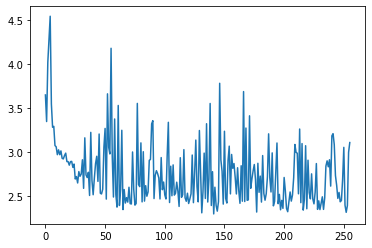

Let's try it!

Given:
	'frightened at the sudden '

predicted:
	'frightened at the sudden  | the the the the the the the the the the the the the the the the the the the the the the the the the '

Given:
	'ed to find that she began |  shrinking directly. as soon as she was small enough to get through the door, she ran out of the hou'

predicted:
	'ed to find that she began | dtoe ng ng ton  e e   n tauu tn toe tot toeti tadu  ethuto  ahe    ethe touu  toe tondtu htu the ter'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

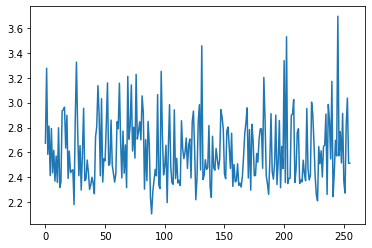

Let's try it!

Given:
	'rned crimson with fury, a'

predicted:
	'rned crimson with fury, a | nd the the the the the the the the the the the the the the the the the the the the the the the the t'

Given:
	'ver left off staring at t | he hatter, and, just as the dormouse crossed the court, she said to one of the officers of the court'

predicted:
	'ver left off staring at t | he tath    and  aor  tn the toueeu   to u    the tou    toe tonn thutud tu the tu  ne   tu the tout '
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

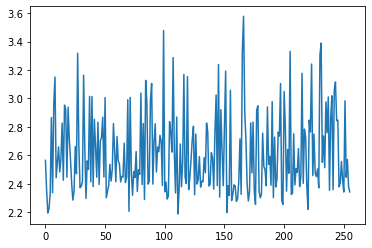

Let's try it!

Given:
	'oldiers remaining behind '

predicted:
	'oldiers remaining behind  | the the the the the the the the the the the the the the the the the the the the the the the the the '

Given:
	'wn, all of you, and liste | n to me! i'll soon make you dry enough!' they all sat down at once, in a large ring, with the mouse '

predicted:
	'wn, all of you, and liste |   thute  an   tauu tot  tou t   ta u  e  the  tni tot t ue tn tu e  an tntat   tang  ton ethe tout  '
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

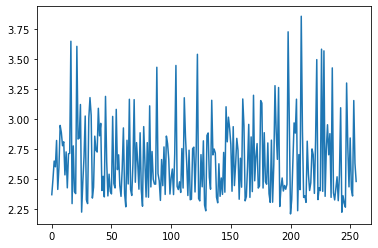

Let's try it!

Given:
	'ould chance to be     inv'

predicted:
	'ould chance to be     inv | e the the the the the the the the the the the the the the the the the the the the the the the the th'

Given:
	',' she added aloud.  'do  | you mean that you think you can find out the answer to it?' said the march hare.  'exactly so,' said'

predicted:
	',' she added aloud.  'do  | t u to tdthe  t u theng tou totdtong tu hthe tnd    thitn   tatd the tor eete     ao  ne e tou  tatd'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

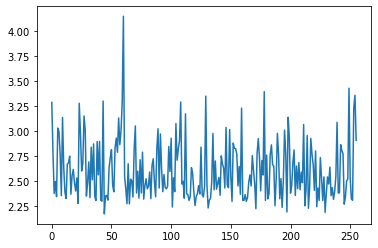

Let's try it!

Given:
	'ked her arm affectionatel'

predicted:
	'ked her arm affectionatel |  the the the the the the the the the the the the the the the the the the the the the the the the the'

Given:
	't on growing, and, as a l | ast resource, she put one arm out of the window, and one foot up the chimney, and said to herself 'n'

predicted:
	't on growing, and, as a l | ar  ta  u  e  aoe tor tu  tn etu  tu the ton      nd tud touu ta the toene    'nd totn thute    i to'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

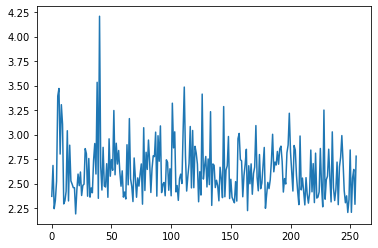

Let's try it!

Given:
	'nd when she had got its h'

predicted:
	'nd when she had got its h | e the the the the the the the the the the the the the the the the the the the the the the the the th'

Given:
	'elt sure it would all com | e wrong, and she went on in a trembling voice:--    'i passed by his garden, and marked, with one ey'

predicted:
	'elt sure it would all com | e to u   and toe tor  tudtngtnthe eeing teute  - taaaanton    ta ten tot   g  nd tot     aon etu  ta'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

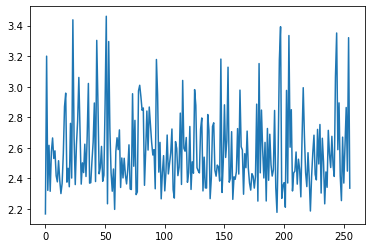

Let's try it!

Given:
	'here alice could see it t'

predicted:
	'here alice could see it t | he the the the the the the the the the the the the the the the the the the the the the the the the t'

Given:
	's the matter worse. you m | ust have meant some mischief, or else you'd have signed your name like an honest man.'  there was a '

predicted:
	's the matter worse. you m | or  te e to td toue ton een   auetai  tou   tere ton    tou  tote tan  tn teud  htend  tahe   tas tn'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

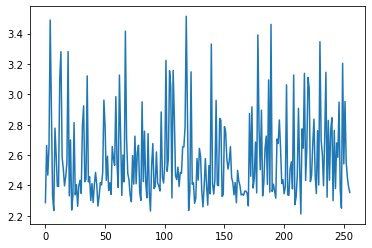

Let's try it!

Given:
	'-how was it, old fellow? '

predicted:
	'-how was it, old fellow?  | the the the the the the the the the the the the the the the the the the the the the the the the the '

Given:
	'and lonely on a little le | dge of rock, and, as they came nearer, alice could hear him sighing as if his heart would break. she'

predicted:
	'and lonely on a little le |     tu toue  and  an the  tate to t    'nene tou e te t taneton eng tn tn ten te    tau   ta  n   oe'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

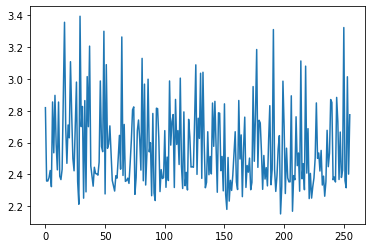

Let's try it!

Given:
	'roughly to your little bo'

predicted:
	'roughly to your little bo | u the the the the the the the the the the the the the the the the the the the the the the the the th'

Given:
	'y it'll seem to come out  | among the people that walk with their heads downward! the antipathies, i think--' (she was rather gl'

predicted:
	'y it'll seem to come out  | tne g the toru e the  tat  tan ethe n ta t  t ue     'the tnd n n en   antheng -- ta e tot ton e  ta'
Training...


  0%|          | 0/256 [00:00<?, ?it/s]

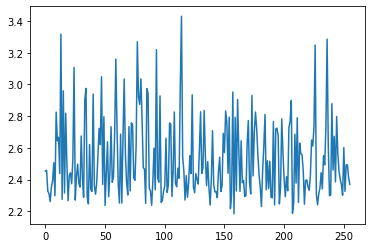

Let's try it!

Given:
	'g to what i could say if '

predicted:
	'g to what i could say if  | the the the the the the the the the the the the the the the the the the the the the the the the the '

Given:
	'me is alice, so please yo | ur majesty,' said alice very politely; but she added, to herself, 'why, they're only a pack of cards'

predicted:
	'me is alice, so please yo | u  tatd      ta d tnene te   tauen     tor toe tn     ahute    i  to e  ahe     'u   tntore tu tet  '


In [6]:
for i in range(10):
    print("Training...")
    train(epochs = 256, batch_size = 256)
    print("Let's try it!")
    try_it(times = 1, length = 100)
    try_it_easier(length = 100)